In [1]:
import os
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt
import seaborn as sns
import modules_TFM as mod

from scipy.optimize import curve_fit
from scipy.stats import binned_statistic_2d
from scipy.stats import binned_statistic

In [2]:
import time
print(' Last revision ', time.asctime())
frames = []

for ifile in range(0, 8000): # Bucle para leer cada archivo individualmente 
    
    file = f'/Users/pablo/OneDrive - Universidade de Santiago de Compostela/Máster/TFM/dorothea/dorothea_{ifile}_kr83m.h5'

    if os.path.exists(file): # En caso de que el path del archivo exista, lo abre como DataFrame 
        
        if ifile%2==0: 
            
            #print(file)
            
            dst = pd.DataFrame(tb.open_file(file).root.DST.Events[:]) 

            frames.append(dst) # Guarda cada uno de los DataFrames en una lista
            
kdst = pd.concat(frames, ignore_index=True) # Hace un nuevo DataFrame juntando los individuales

kdst

 Last revision  Thu Nov 21 16:16:37 2024


,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
0,1600,1.601953e+09,0,0,1,1,200.0,7.0,19.0,10000.0,...,9,669.487854,562.369751,3.578721,-459.760008,-55.820768,463.136290,-3.020771,11.071444,10.575179
1,1602,1.602744e+09,0,0,1,1,125.0,5.0,15.0,10000.0,...,7,548.483154,460.725830,3.178156,-453.294198,-161.574950,481.229773,-2.799187,9.536605,10.081681
2,1604,1.605633e+09,0,0,1,1,250.0,3.0,14.0,10000.0,...,8,151.499710,127.259750,1.900903,443.049486,-14.897329,443.299873,-0.033612,9.465026,10.122552
3,1606,1.607813e+09,0,0,1,1,175.0,6.0,17.0,10000.0,...,8,516.493958,433.854889,3.219601,409.438144,-247.895722,478.635439,-0.544420,10.356321,10.591151
4,1608,1.608176e+09,0,0,1,1,175.0,4.0,15.0,10000.0,...,8,363.481140,305.324158,2.673991,-36.718107,-461.022901,462.482794,-1.650273,9.796269,10.497626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490087,6399190,6.399191e+12,0,0,1,1,250.0,5.0,21.0,10050.0,...,9,962.429321,808.440552,4.166302,-22.263757,224.603664,225.704410,1.669598,11.410413,11.547462
1490088,6399192,6.399192e+12,0,0,1,1,200.0,8.0,22.0,10000.0,...,9,1404.501953,1179.781616,4.982812,240.522545,-164.642069,291.475738,-0.600260,11.732220,10.877596
1490089,6399194,6.399195e+12,0,0,1,1,200.0,4.0,12.0,10050.0,...,7,435.438019,365.767914,2.907131,206.605181,-53.940802,213.530585,-0.255381,9.354601,10.132411
1490090,6399196,6.399196e+12,0,0,1,1,125.0,3.0,9.0,10000.0,...,6,315.484100,265.006622,2.488038,65.532921,-44.267010,79.083069,-0.594088,8.805151,8.863330


## PROFILE DE LOS DATOS

Aquí se estudia como es la tendencia de los datos que tenían una más alta correlación entre sí

In [3]:
def profiles(xdata,ydata,n_bins=50,x_label=None, y_label=None,plot=False):
    '''
    xdata: np.array or 1 column dataframe with data for the x-axes
    ydata: np.array or 1 column dataframe with data for the x-axes
    n_bins: must be an integer, number of bins for the histogram. Default value: 50 could change if you had poor statistic
    x_label: string that contains the name of the magnitude in the x axes
    y_label: string that contains the name of the magnitude in the y axes
    ######
    Output: returns a plot with the profile of ydata as a function of xdata. This profile is superposed over an histogram of the number of events so we can check if the statistic is good enough to consider one point as relevant.
    '''        
    ydata_filtered = np.array([s for s, d in zip(ydata, xdata) if d > 10])
    xdata_filtered = np.array([i for i in xdata if i> 10])
    
    mean_y, bin_edges, _ = binned_statistic(xdata_filtered, ydata_filtered, statistic='mean', bins=n_bins)
    std_y, _, _ = binned_statistic(xdata_filtered, ydata_filtered, statistic='std', bins=n_bins)
    count, _, _ = binned_statistic(xdata_filtered, ydata_filtered, statistic='count', bins=n_bins)

    if mean_y.any()<0: print(True)
    else: print(False)

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    uncertainty = std_y / np.sqrt(count)
    if plot==True:
        fig, ax1 = plt.subplots()
    
        ax1.plot(bin_centers, mean_y, 'bo', label='Average of {y_label}')
        ax1.set_xlabel(x_label)
        ax1.set_ylabel(f"Average {y_label}", color='b')
        ax1.tick_params(axis='y', labelcolor='b')
        ax1.set_title(f"Average {y_label} Profile vs {x_label}")
    
        ax2 = ax1.twinx()
        ax2.bar(bin_centers, count, width=(bin_edges[1] - bin_edges[0]), alpha=0.5, color='gray', label='Number of events', edgecolor='black')
        ax2.set_ylabel("Number of events", color='gray')
        ax2.tick_params(axis='y', labelcolor='gray')
    
        fig.tight_layout()
    
        plt.figure()
        plt.plot(mean_y, uncertainty, 'b.')
        plt.ylabel(f'Uncertainty in {y_label}')
        plt.xlabel(f'{y_label}')
        plt.grid(True)
        
        plt.show()

The code above defines a function that plots the profile of a magnitude as a function of an x magnitude given. First of all, filters data so we do not consider anomalous points as those with DT<0 (as it doesn´t have any physical sense), after that, computes the points that will be seen in the plot using the function scipy.stats.binned_statistic, finally computes the centers of the bins and the uncertainity associated to each point. Then magnitudes are plotted. 

In [4]:
n_bins = 50

s2w = kdst['S2w']
s2h = kdst['S2h']
s2e = kdst['S2e']
s2q = kdst['S2q']
s1w = kdst['S1w']
s1h = kdst['S1h']
s1e = kdst['S1e']

y_data_frames=[s2w,s2h,s2e,s2q,s1w,s1h,s1e]

DT = kdst['DT']

In [5]:
#for elemento in y_data_frames:
 #   profiles(DT,elemento,x_label='DT',y_label=f'{elemento}.title()')
    

Let's first study the S2 signal with DT. Firstly we will see S2w.

False


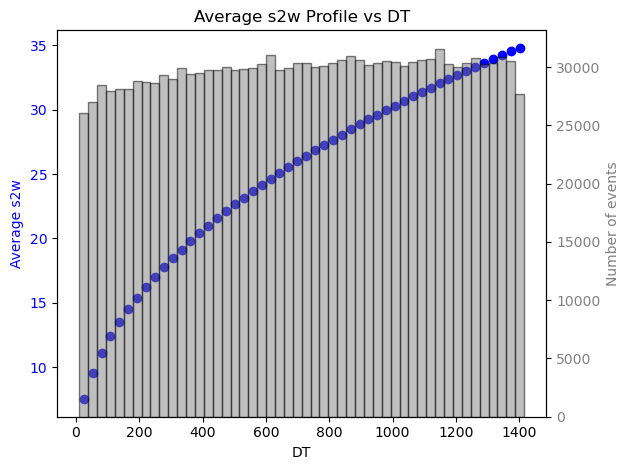

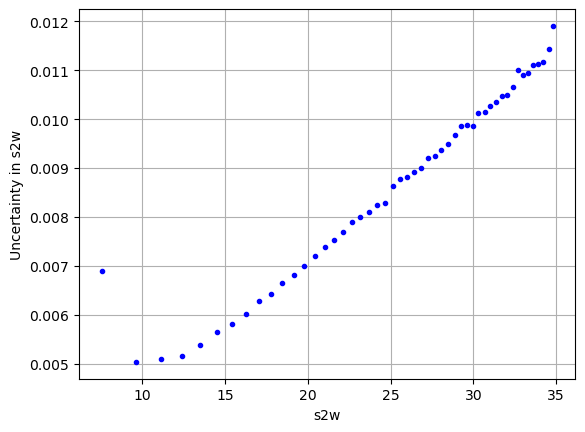

In [6]:
profiles(DT, s2w, x_label='DT', y_label='s2w',plot=True)

For this case, the signal we got makes sense as it is normal to have a narrow signal when we get close to the detection plane, as we will have less diffusive effects or losses due to other effects. On the other hand, ther average of S2w grows approximately as $\sqrt N$. The uncertainity of the width grows as it gets wider, which was expected.

Let's see S2h

False


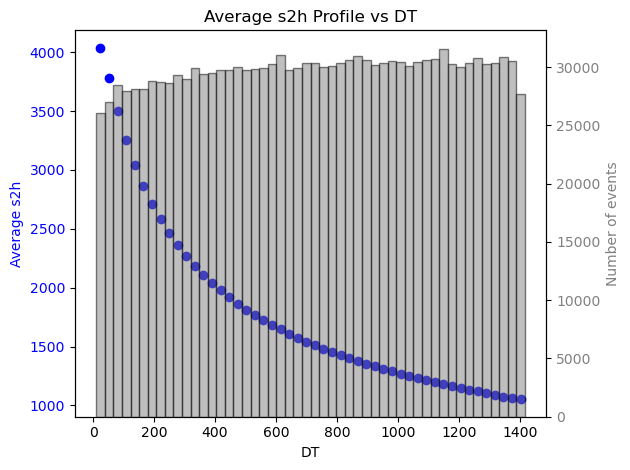

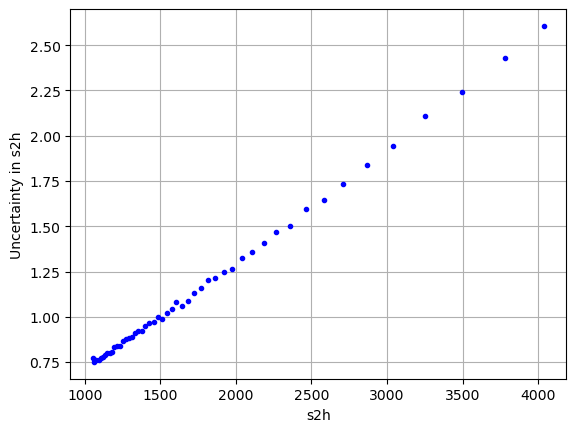

In [7]:
profiles(DT, s2h, x_label='DT', y_label='s2h',plot=True)

It makes sense to expect a profile with this shape because, as stated before, close to the detection plane diffusive effects will not be as important and, in the plane $DT\approx 0$ the signal has maximum energy and height. The integral of the signal (this is, the energy) is bigger as the height of the signal increases. The uncertainity also increases with S2h.

Vamos a ver ahora el perfil de S2e

False


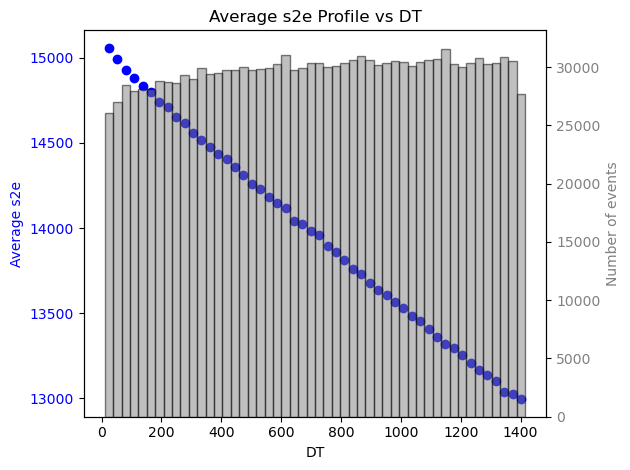

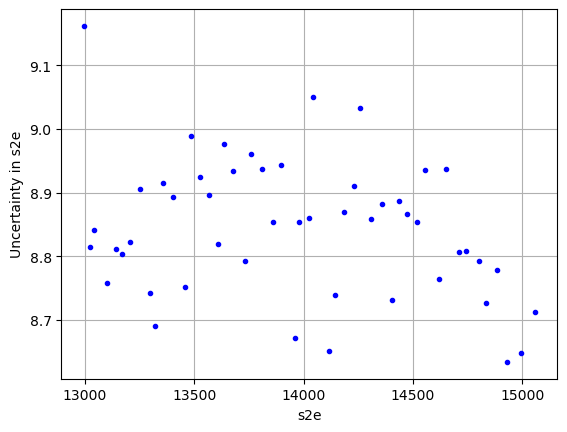

In [8]:
profiles(DT, s2e, x_label='DT', y_label='s2e',plot=True)

Vemos un perfil parecido al que veíamos el otros día. Un decaimiento exponencial fácilmente aproximable por una recta. La incertidumbre de la energía a priori son puntos dispersos, fijándonos en la escala del eje y, la variación es entre el máximo y el mínimo es $\approx 0.5$(pes). Estamos trabajando en un rango de incertidumbres de aproximadamente decenas de pes de forma que puede considerarse una incertidumbre aproximadamente constante 

Ahora para la carga que lleva la señal

False


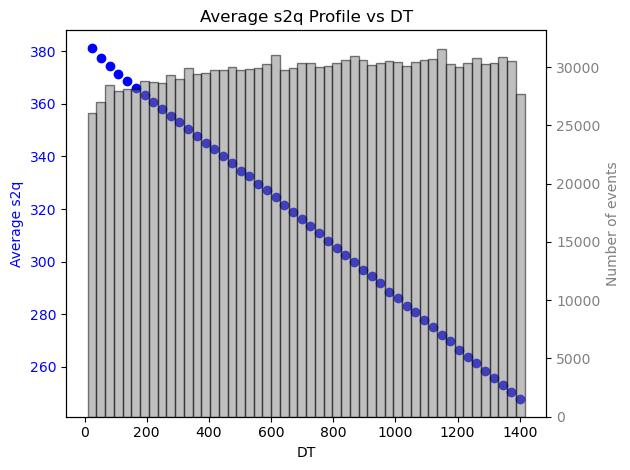

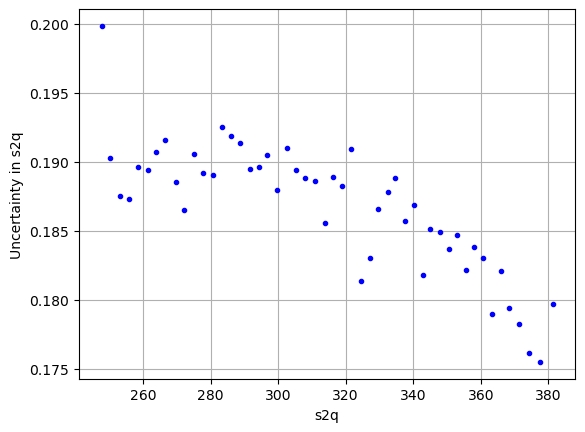

In [9]:
profiles(DT, s2q, x_label='DT', y_label='s2q',plot=True)

La carga cae linealmente con el drift time. Una caída de la carga es esperable, porque algunos de los electrones pueden recombinar, interaccionar, etc... y entonces la carga que vemos será menor. La incertidumbre cae a medida aumenta s2q en un 0.015 aprox.

### Veamos ahora la señal S1

Empezamos viendo ahora, al igual que para el caso de S2, como varía S1w con el DT.

False


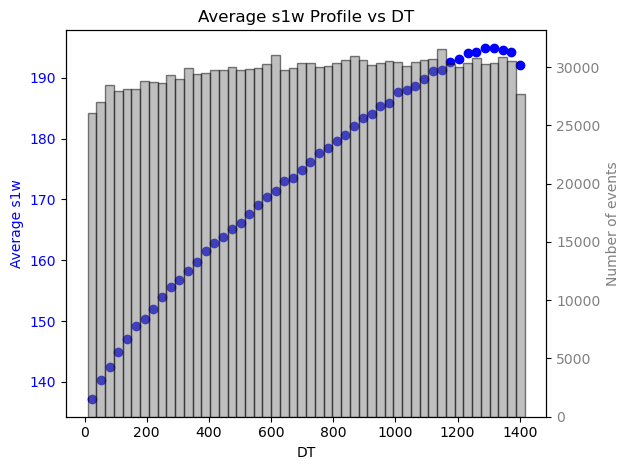

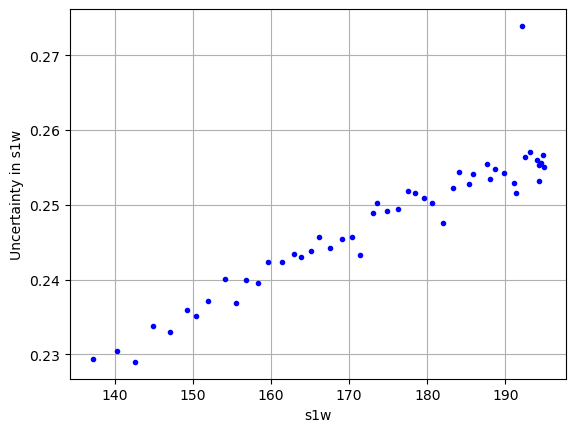

In [10]:
profiles(DT, s1w, x_label='DT', y_label='s1w',plot=True)

Las ener


False


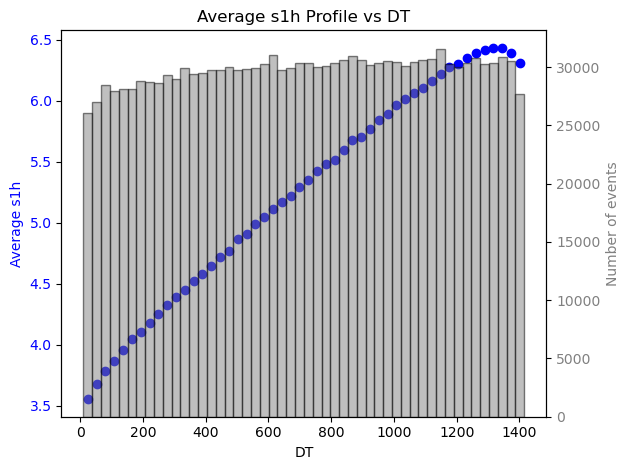

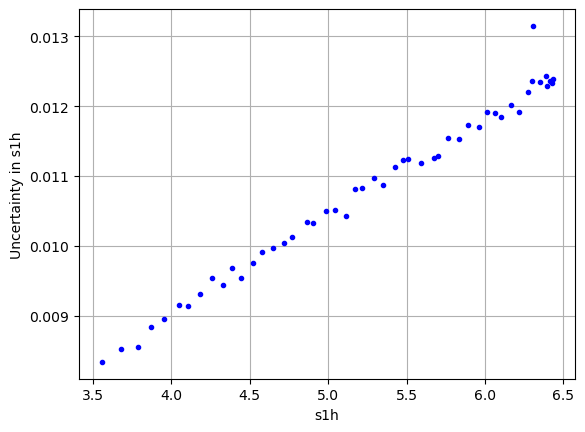

In [11]:
profiles(DT, s1h, x_label='DT', y_label='s1h',plot=True)

The S1 is measured in the EP. The maximum energy is then where DT is maximum as it has its origin in the trcking plane


In [12]:
profiles(DT, s1e, x_label='DT', y_label='s1e')

False


False


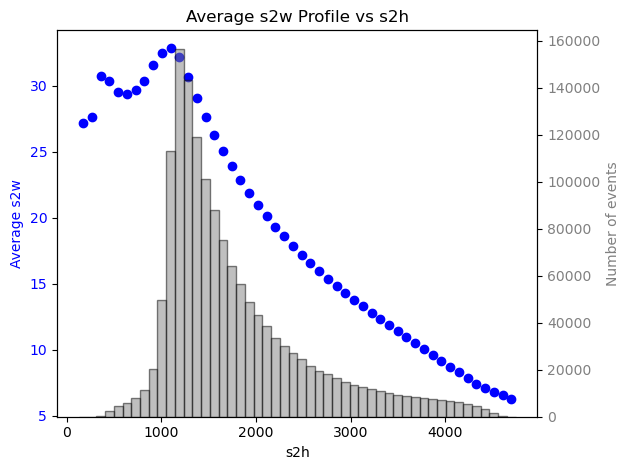

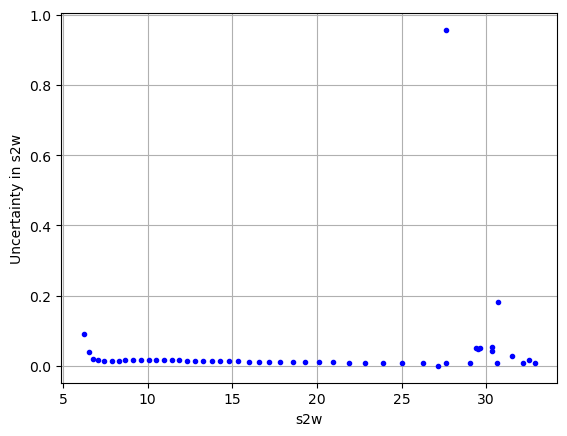

In [13]:
profiles(s2h,s2w,x_label='s2h',y_label='s2w',plot=True)

Tiene sentido, tendremos un número menor de eventos con una altura muy alta y se debería corresponder a eventos de más energía, son eventos que ocurren más cerca del plano de energías. En los eventos con más altura de s2 hay menos fenómenos de difusión y entonces decrece la anchura de la señal

False


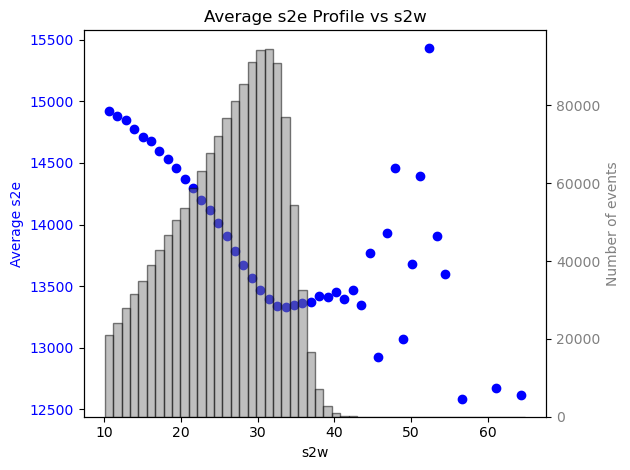

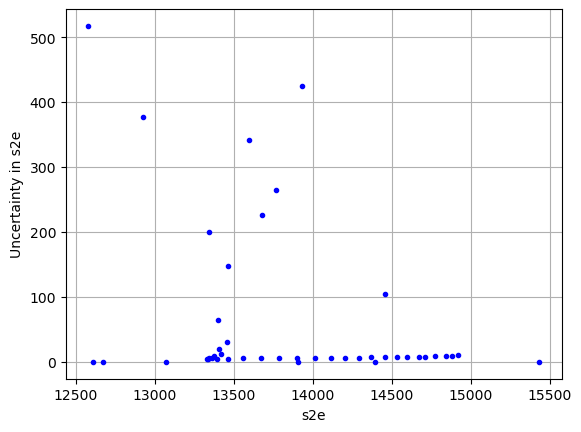

In [14]:
profiles(s2w,s2e,x_label='s2w',y_label='s2e',plot=True)

False


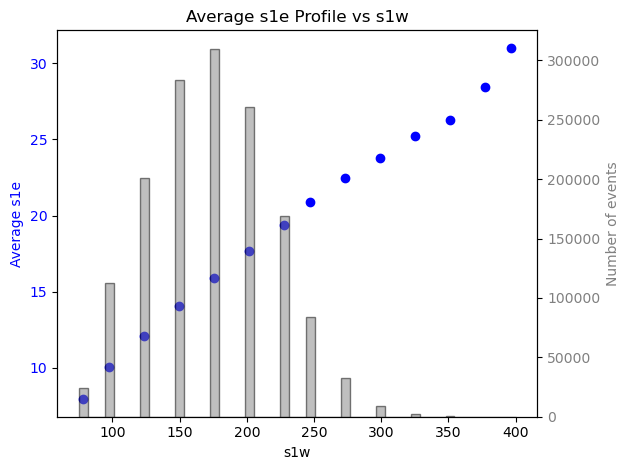

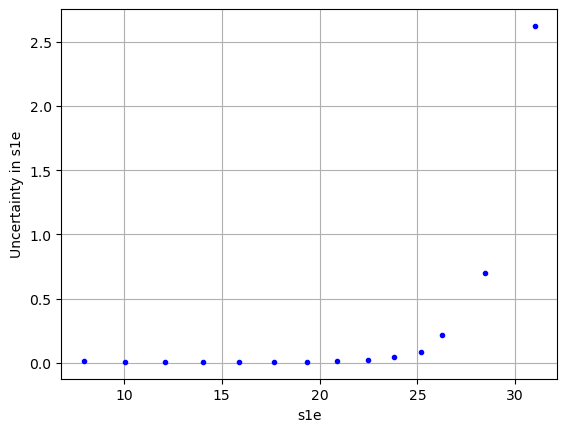

In [15]:
s1w = kdst['S1w']
s1h = kdst['S1h']
s1e = kdst['S1e']

profiles(s1w,s1e,x_label='s1w',y_label='s1e',plot=True)

Un poco la misma idea que antes

False


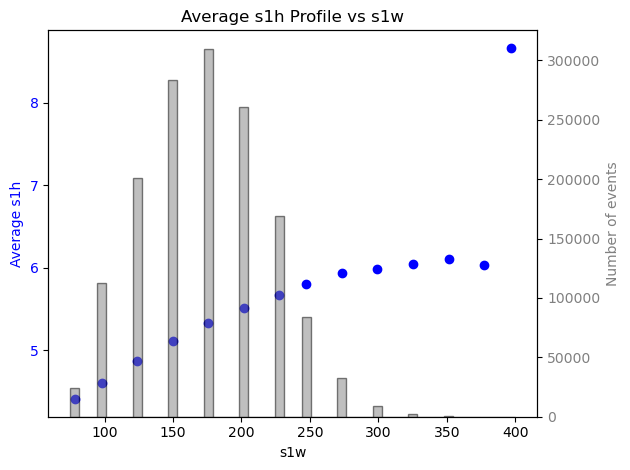

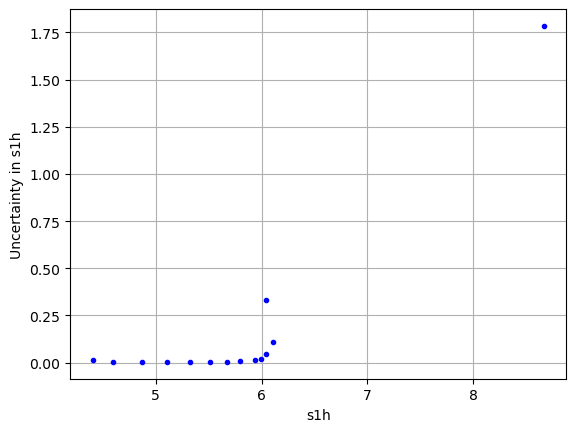

In [16]:
profiles(s1w,s1h,x_label='s1w',y_label='s1h',plot=True)

### Ajustes Repetidos.

Para empezar hago el mismo filtro que en el notebook anterior para quedarme solo con eventos que tienen lugar en un cilindro estrecho centrado en el origen del plano XY  

In [17]:
energías_eventos_centrales=[]
posicion_axial=[]

energías_eventos_externos=[]
posicion_externa=[]

for i in range(len(kdst['S2e'])):
    if kdst['R'][i]<=np.sqrt(2*75**2):
        energías_eventos_centrales.append(kdst['S2e'][i])
        posicion_axial.append(kdst['DT'][i])
    else:
        energías_eventos_externos.append(kdst['S2e'][i])
        posicion_externa.append(kdst['DT'][i])
        
print('El porcentaje de eventos en un radio menor de 105mm es',np.round(len(posicion_axial)/len(kdst['DT'])*100,3),'%')
print('El porcentaje de eventos en un radio mayor de 105mm es',np.round(len(posicion_externa)/len(kdst['DT'])*100,3),'%')


El porcentaje de eventos en un radio menor de 105mm es 4.853 %
El porcentaje de eventos en un radio mayor de 105mm es 95.147 %


Separo los eventos en grupos que contienen datos de 100 eventos

In [18]:
series_de_datos_separadas_energías = [energías_eventos_centrales[100*i:100*i+100] for i in range(len(energías_eventos_centrales))]
series_de_datos_separadas_posiciones = [posicion_axial[100*i:100*i+100] for i in range(len(posicion_axial))]

Ajusto cada uno de las series y almaceno la media de $\tau$, la $E_0$ y sus incertidumbres.

In [19]:
def atenuacion_exponencial(x,mu,E0):
    return E0*np.exp(-x/mu)

media_tau=[]
media_E0=[]

incertidumbre_tau=[]
incertidumbre_E0=[]

for i in range(int(len(series_de_datos_separadas_energías)/100)):
    popt,pcov=curve_fit(atenuacion_exponencial,series_de_datos_separadas_posiciones[i],series_de_datos_separadas_energías[i],p0=[10000,1600])
    if popt[0]<13000 and popt[0]>1600:
        media_tau.append(popt[0]);media_E0.append(popt[1])
        incertidumbre_tau.append(np.sqrt(pcov[0][0]));incertidumbre_E0.append(np.sqrt(pcov[1][1]))

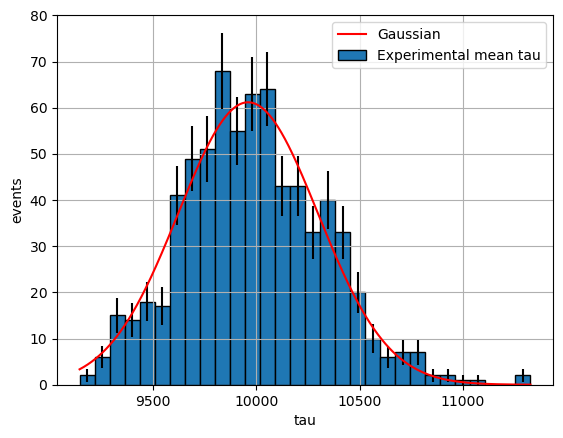

The expected value for tau is 9960.016412238432 +- 14.537556033069215


In [20]:
counts, bin_edges, _ = binned_statistic(media_tau, media_tau, statistic='count', bins=30)
errors = np.sqrt(counts)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.bar(bin_centers, counts, width=np.diff(bin_edges), edgecolor='black',label='Experimental mean tau')
plt.errorbar(bin_centers, counts, yerr=errors, fmt='none', color='black')
plt.xlabel('tau');plt.ylabel('events')

def gaussian(x,N,mu,sigma):
    return N*np.exp(-1/2*(x-mu)**2/sigma**2)

popt,pcov=curve_fit(gaussian, bin_centers, counts, p0=[70,16475,1000])
xplot=np.linspace(min(media_tau),max(media_tau),1000)
plt.plot(xplot,gaussian(xplot,*popt),color='red',label='Gaussian')
plt.legend(loc='best')
plt.grid(True)

plt.show()

expected_tau=popt[1]

print('The expected value for tau is', expected_tau,'+-', np.sqrt(pcov[1][1]))

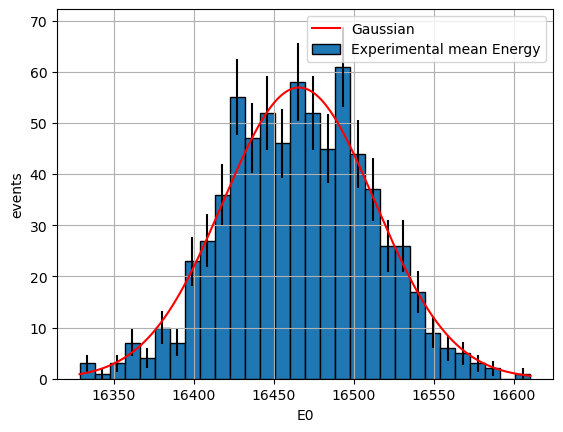

The expected value for E0 is 16465.747899436068 +- 1.9842546459535297


In [21]:
counts, bin_edges, _ = binned_statistic(media_E0, media_E0, statistic='count', bins=30)
errors = np.sqrt(counts)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.bar(bin_centers, counts, width=np.diff(bin_edges), edgecolor='black', label='Experimental mean Energy')
plt.errorbar(bin_centers, counts, yerr=errors, fmt='none', color='black')
plt.xlabel('E0');plt.ylabel('events')

def gaussian(x,N,mu,sigma):
    return N*np.exp(-1/2*(x-mu)**2/sigma**2)

popt,pcov=curve_fit(gaussian, bin_centers, counts, p0=[70,16475,1000])
xplot=np.linspace(min(media_E0),max(media_E0),1000)
plt.plot(xplot,gaussian(xplot,*popt),color='red',label='Gaussian')
plt.legend(loc='best')
plt.grid(True)

plt.show()

expected_E0=popt[1]
print('The expected value for E0 is', expected_E0,'+-', np.sqrt(pcov[1][1]))

Siguen una distribución gaussiana, como queríamos ver

### Histogram with uncertainities and pull.

Firstly we will plot an histogram with the uncertainities for $\tau$ and $E_0$

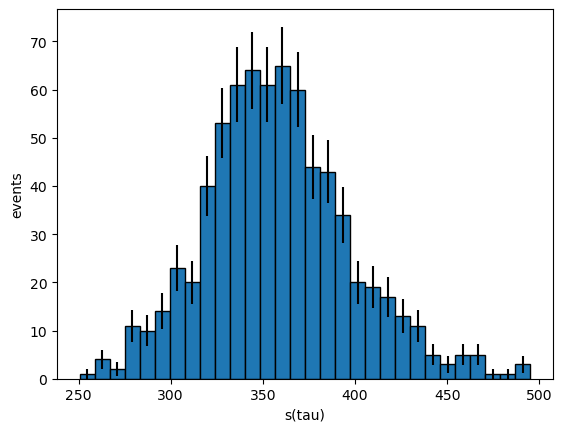

In [22]:
counts, bin_edges, _ = binned_statistic(incertidumbre_tau, incertidumbre_tau, statistic='count', bins=30)
errors = np.sqrt(counts)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.bar(bin_centers, counts, width=np.diff(bin_edges), edgecolor='black')
plt.errorbar(bin_centers, counts, yerr=errors, fmt='none', color='black')

plt.xlabel('s(tau)');plt.ylabel('events')

plt.show()

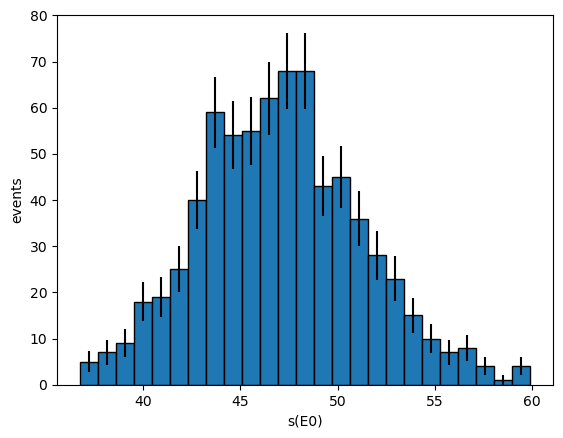

In [23]:
counts, bin_edges, _ = binned_statistic(incertidumbre_E0, incertidumbre_E0, statistic='count', bins=25)
errors = np.sqrt(counts)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.bar(bin_centers, counts, width=np.diff(bin_edges), edgecolor='black')
plt.errorbar(bin_centers, counts, yerr=errors, fmt='none', color='black')

plt.xlabel('s(E0)');plt.ylabel('events')

plt.show()

We see we get the expected shape, as the uncertainities should have a similar gaussian form to the magnitudes itself

We now normlize the parameters to its mean, this is the pull.

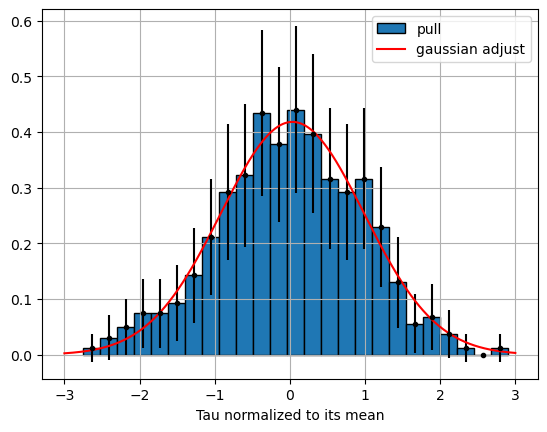

The parameters of the adjust are mu=0.03420709548638717+-0.03279672959267581 and sigma=0.9542442456900472+-0.0328650773704503


In [24]:
tau_measured=np.array([media_tau])
sigma_tau=np.array([incertidumbre_tau])

normalized_tau=(tau_measured-expected_tau)/sigma_tau
counts, bin_edges = np.histogram(normalized_tau.T, bins=25, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])  
errors = np.sqrt(counts) / np.sum(counts)  

plt.hist(normalized_tau.T, bins=25, edgecolor='black', density=True, label='pull')
plt.errorbar(bin_centers, counts, yerr=errors,fmt='.', color='black')

popt,pcov=curve_fit(gaussian, bin_centers,counts,p0=[0.4,0,1])
xplot=np.linspace(-3,3,1000)
plt.plot(xplot, gaussian(xplot,*popt), color='red',label='gaussian adjust')
plt.grid(True)
plt.legend(loc='best')

plt.xlabel("Tau normalized to its mean")
plt.show()

print(f'The parameters of the adjust are mu={popt[1]}+-{np.sqrt(pcov[1][1])} and sigma={popt[2]}+-{np.sqrt(pcov[2][2])}')

These correspond with what would be expected in a normal distibution, so our parameters are well determined

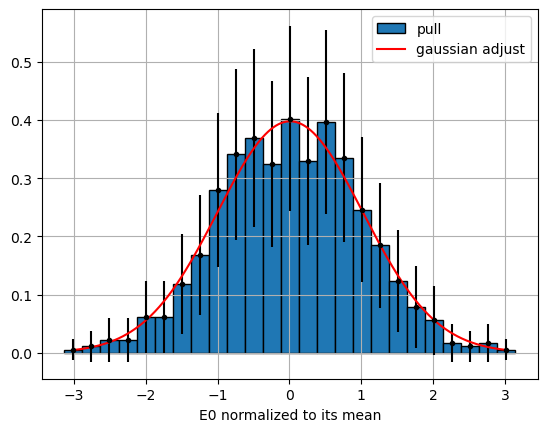

The parameters of the adjust are mu=0.008832370276454242+-0.035345781721017246 and sigma=1.0124053137839053+-0.035381584932138194


In [25]:
E0_measured=np.array([media_E0])
sigma_E0=np.array([incertidumbre_E0])

normalized_E0=(E0_measured-expected_E0)/sigma_E0
counts, bin_edges = np.histogram(normalized_E0.T, bins=25, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])  
errors = np.sqrt(counts) / np.sum(counts)  

plt.hist(normalized_E0.T, bins=25, edgecolor='black', density=True, label='pull')
plt.errorbar(bin_centers, counts, yerr=errors,fmt='.', color='black')

popt,pcov=curve_fit(gaussian, bin_centers,counts,p0=[0.4,0,1])
xplot=np.linspace(-3,3,1000)
plt.plot(xplot, gaussian(xplot,*popt), color='red',label='gaussian adjust')
plt.grid(True)
plt.legend(loc='best')

plt.xlabel("E0 normalized to its mean")
plt.show()

print(f'The parameters of the adjust are mu={popt[1]}+-{np.sqrt(pcov[1][1])} and sigma={popt[2]}+-{np.sqrt(pcov[2][2])}')

These correspond with what would be expected in a normal distibution, so our parameters are well determined

### Dependency of S1e with R and DT

Let's take a look to the energy of the S1 signal. Let's study it in terms of the points in the plane $XY$ where the event starts, this is the magnitude $R$, and the axial position $DT$ (Note: the origin in DT is in the tracking plane so the maximum in DT corresponds to an event produced next to the energy plane.) 


Now we plot in a color map the energy of the event with respect the position.

El porcentaje de eventos dentro de este corte es 43.279%


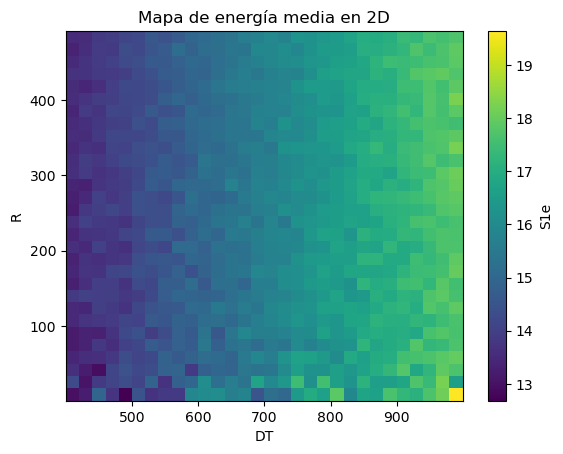

In [26]:
R=kdst['R']
s1e=kdst['S1e']
DT=kdst['DT']

s1e_filter, DT_filter, R_filter=mod.radius_filter(s1e,R,DT,400,1000)

mean_E, x_edges,y_edges,binned = binned_statistic_2d(DT_filter, R_filter, s1e_filter, statistic='mean', bins=30)
X, Y = np.meshgrid(x_edges, y_edges)

fig, ax = plt.subplots()  
c = ax.pcolormesh(X, Y, mean_E.T, cmap='viridis')
plt.colorbar(c, label='S1e')
plt.xlabel('DT')
plt.ylabel('R')
plt.title('Mapa de energía media en 2D')
 

plt.show()

We see that, as DT increases, we measure events with higher primary scillation energy, being the maximum where $R\rightarrow 0$ and $DT\rightarrow 1000$ this is the center of the camera and the closest to the energy plane.

### Why does S2e increase as the decrease DT and why does S1e increase as DT grows?


If I have it right, the drift time is the time that takes to the electrons to reach the tracking plane (TP). This is, if the event takes place really close to the TP the electrons will suffer almost no energy losses due to diffusion or other attenuantion effects. What this means is that they will reach the EL zone with the maximum energy and then they will produce the maximum photons, so the scillation light will be so intense. However if we go further, the energy of the electrons will be smaller so they will produce less light and the S2e measured in the energy plane (EP) will be lower.

On the other hand, S1e is directly scillation light, so it will be directly measured in the EP, the closer we are to that plane (this is a longer DT) we will collect more primary photons and then the energy of the signal measured will higher.

### ajustar s2q-dt

### datos electron (IRM)

In [27]:
#kdst[(kdst.DT > 60) & (kdst.DT < 100)][['S1w', 'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'qmax', 'Nsipm', 'DT']]

In [28]:
#kdst[kdst.DT > 1200][['S1w', 'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'qmax', 'Nsipm', 'DT']]

In [29]:
#for i in range(len(kdst['S2w'])):
 #   if kdst['S2w'][i]<0:
  #      print(i)